In [1]:
from time import time
from move_dataset import MoveDataset
import argparse
from keras_fcn import build_fcn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard
import torch
import matplotlib.pyplot as plt
import seaborn as sns

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
dataset = MoveDataset(pickle_file='move_data.pkl')

In [3]:
model = tf.keras.models.load_model('model.h5')

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 2)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 128)          2176      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 128, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 256)          164096    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 256)          0     

In [5]:
import argparse
from move_dataset import MoveDataset
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from keras_utils import get_model_output_features, truncate_model
from sklearn.svm import OneClassSVM
from sklearn import metrics
import numpy as np
from random import uniform
import pandas as pd

dataset = MoveDataset(pickle_file='move_data.pkl')

X, y_onehot = dataset.train_data()
X = preprocessing.StandardScaler().fit_transform(X.reshape(-1, 256)).reshape(-1, 128, 2)

# One hot vector to single value vector
y = np.argmax(y_onehot, axis=1)

# Source: https://github.com/margitantal68/sapimouse/blob/40b5ea6cf10c6f1d64b9dd0427d21138cc4f75e2/util/oneclass.py#L40
def compute_AUC_EER(positive_scores, negative_scores):
    zeros = np.zeros(len(negative_scores))
    ones = np.ones(len(positive_scores))
    y = np.concatenate((zeros, ones))
    scores = np.concatenate((negative_scores, positive_scores))
    fpr, tpr, _ = metrics.roc_curve(y, scores, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    fnr = 1 - tpr
    EER_fpr = fpr[np.argmin(np.absolute((fnr - fpr)))]
    EER_fnr = fnr[np.argmin(np.absolute((fnr - fpr)))]
    EER = 0.5 * (EER_fpr + EER_fnr)
    return roc_auc, EER, fpr, tpr

# Source: https://github.com/margitantal68/sapimouse/blob/40b5ea6cf10c6f1d64b9dd0427d21138cc4f75e2/util/oneclass.py#L138
def score_normalization(positive_scores, negative_scores):
    scores = [positive_scores, negative_scores]
    scores_df = pd.DataFrame(scores)

    mean = scores_df.mean()
    std = scores_df.std()
    min_score = mean - 2 * std
    max_score = mean + 2 * std

    min_score = min_score[0]
    max_score = max_score[0]

    positive_scores = [(x - min_score) / (max_score - min_score) for x in positive_scores]
    positive_scores = [(uniform(0.0, 0.05) if x < 0 else x) for x in positive_scores]
    positive_scores = [(uniform(0.95, 1.0) if x > 1 else x) for x in positive_scores]

    negative_scores = [(x - min_score) / (max_score - min_score) for x in negative_scores]
    negative_scores = [uniform(0.0, 0.05) if x < 0 else x for x in negative_scores]
    negative_scores = [uniform(0.95, 1.0) if x > 1 else x for x in negative_scores]
    return positive_scores, negative_scores    

In [6]:
model = truncate_model(model)

user_stats = {}
auc_list = []
eer_list = []
global_positive_scores = list()
global_negative_scores = list()

# Computer scores for first 10 users
for userid in range(10):
    if np.count_nonzero(y == userid) == 0:
        continue
    X_positive = X[y == userid]
    X_negative = X[y != userid]

    # Extract new features from dx, dy vectors
    X_positive_features = get_model_output_features(model, X_positive)
    X_negative_features = get_model_output_features(model, X_negative)

    clf = OneClassSVM(gamma='scale')
    clf.fit(X_positive_features)
    
    positive_scores = clf.score_samples(X_positive_features)
    negative_scores = clf.score_samples(X_negative_features)

    auc, eer, _, _ = compute_AUC_EER(positive_scores, negative_scores)

    positive_scores, negative_scores = score_normalization(positive_scores, negative_scores)
    print('for user', userid, ': auc:', auc, 'eer:', eer)
    auc_list.append(auc)
    eer_list.append(eer)
    user_stats[userid] = (auc, eer)
    global_positive_scores.extend(positive_scores)
    global_negative_scores.extend(negative_scores)
#     print(positive_scores, negative_scores)

global_auc, global_eer, fpr, tpr = compute_AUC_EER(global_positive_scores, global_negative_scores)

for user 0 : auc: 0.7780575212906629 eer: 0.2986887336886468
for user 1 : auc: 1.0 eer: 0.0
for user 2 : auc: 0.9379216593666517 eer: 0.13039177369828844
for user 3 : auc: 0.8835291161814586 eer: 0.15849789520095964
for user 4 : auc: 0.8655043943173129 eer: 0.1940890299092309
for user 5 : auc: 0.8833703844276961 eer: 0.1962467010235181
for user 6 : auc: 0.9601628564712918 eer: 0.08940851413541873
for user 7 : auc: 0.8671131976847957 eer: 0.16039339988270992
for user 8 : auc: 0.9478379815845567 eer: 0.13598693442303567
for user 9 : auc: 0.9861326683956363 eer: 0.0482558957288199


In [13]:
# To do: How to report performance? 
#       option1: Take mean of auc and eer genereated for each user?
#       option2: compute from global positive scores and global negative scores
print(global_auc, global_eer, )
# print(fpr)
# print(tpr)

0.8696777275343095 0.1871071462497203


/home/shalaka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/shalaka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


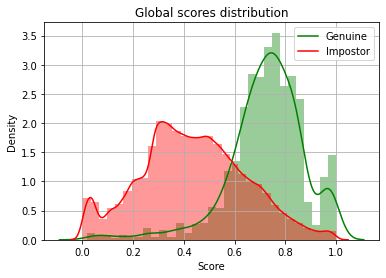

In [16]:
# Source: https://github.com/margitantal68/sapimouse/blob/40b5ea6cf10c6f1d64b9dd0427d21138cc4f75e2/util/plot.py#L15
df = pd.DataFrame([global_positive_scores, global_negative_scores])
BINS = np.linspace(df.min(), df.max(), 31)
sns.distplot(global_positive_scores, norm_hist=True, color='green', bins=31)
sns.distplot(global_negative_scores, norm_hist=True, color='red', bins=31)
plt.legend(['Genuine', 'Impostor'], loc='best')
plt.xlabel('Score')
plt.title('Global scores distribution')
plt.grid()
plt.show()

/home/shalaka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/shalaka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


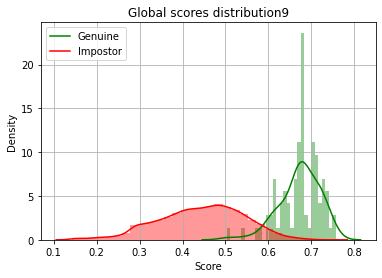

In [17]:
df = pd.DataFrame([positive_scores, negative_scores])
BINS = np.linspace(df.min(), df.max(), 31)
sns.distplot(positive_scores, norm_hist=True, color='green', bins=31)
sns.distplot(negative_scores, norm_hist=True, color='red', bins=31)
plt.legend(['Genuine', 'Impostor'], loc='best')
plt.xlabel('Score')
plt.title('Scores distribution for user '+str(userid))
plt.grid()
plt.show()

In [8]:
# TODO: sample scores randomly

# plt.hist(positive_scores, alpha=0.5, color='green', label='positive')
# plt.hist(negative_scores[:len(positive_scores)],  color='red', alpha=0.5, label='negative')
# plt.legend()
# plt.xlabel('Score')
# plt.ylabel('Density')
# plt.show()

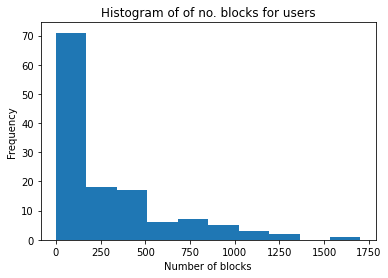

In [17]:
blocks = []
for userid in range(dataset.unique_user_count()):
    blocks.append((X[y == userid]).shape[0])
    
# print(blocks)

plt.hist(blocks)
plt.title('Histogram of of no. blocks for users')
plt.ylabel('Frequency')
plt.xlabel('Number of blocks')
plt.show()

In [18]:
print('average no. of blocks:', np.mean(blocks))

average no. of blocks: 284.0692307692308
